<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Columns" data-toc-modified-id="Columns-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Columns</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Outliers</a></span></li></ul></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train-Test Split</a></span></li><li><span><a href="#Naive-Model" data-toc-modified-id="Naive-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Naive Model</a></span></li><li><span><a href="#AR-Model" data-toc-modified-id="AR-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>AR Model</a></span></li><li><span><a href="#ARIMA-Model" data-toc-modified-id="ARIMA-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>ARIMA Model</a></span></li><li><span><a href="#Facebook-Prophet" data-toc-modified-id="Facebook-Prophet-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Facebook Prophet</a></span></li></ul></div>

# Data Cleaning

In [2]:
# frequently used libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# root mean square error libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
orders_df = pd.read_csv('olist_orders_dataset.csv')
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


## Columns

In [4]:
orders_df.drop(['order_status',
                'customer_id',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date'], axis='columns', inplace=True)
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 2 columns):
order_id                    99441 non-null object
order_purchase_timestamp    99441 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df.dtypes

order_id                            object
order_purchase_timestamp    datetime64[ns]
dtype: object

In [6]:
orders_df[orders_df.duplicated()]

,order_id,order_purchase_timestamp


In [7]:
orders_df.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [8]:
orders_df['purchase_date'] = orders_df['order_purchase_timestamp'].dt.date
raw_daily_sales_df = pd.DataFrame(orders_df.groupby('purchase_date')['order_id'].count())
raw_daily_sales_df.columns = ['sales']
raw_daily_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 2016-09-04 to 2018-10-17
Data columns (total 1 columns):
sales    634 non-null int64
dtypes: int64(1)
memory usage: 9.9+ KB


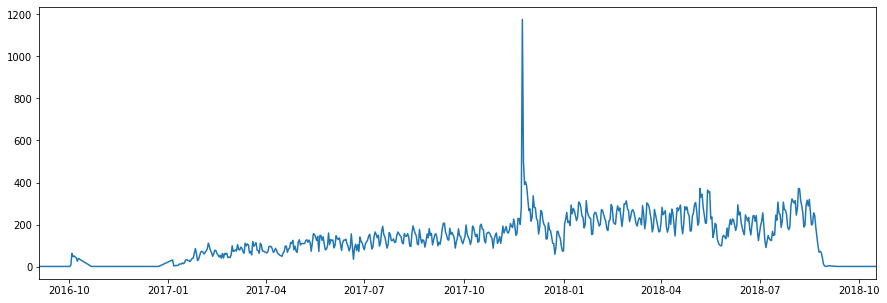

In [9]:
plt.figure(figsize=(15,5))
plt.plot(raw_daily_sales_df)
plt.autoscale(enable=True, axis='x', tight=True)

## Outliers

It is observed that there are three regions of irregularities in the the beginning, middle, and end of the time series. In the begining there are almost no sales until around January of 2017 and even then the sales starts gradualling increasing until it reachs regular sales trends at around April of 2017. This can be associated with the store just starting or switching business. In the middle, there is a significant peak at around new year which represents a lot of people buying new items for themselvs or gifts for others. Finally at the end the sales suddenly decreases from around September 2018 till end where there is no sales what so ever. This can be associated with the store shutting down, switching business, or an unexpected crisis. 

The irregularities in the begining and the end are clearly irrelevant for the purpose of steady-state forcasting. Even though the middle peak can be considered in the forcasting problem, there are no information available about previous cycles, so it was decided to remove all three outliers as follows:

In [42]:
daily_sales_df = raw_daily_sales_df[(raw_daily_sales_df.index > dt.date(2017, 4, 1)) & # remove before April of 2017
                                    (raw_daily_sales_df.index < dt.date(2018, 9, 1)) & # remove after September of 2018
                                    (raw_daily_sales_df.sales < 400)] # remove excessively high peaks

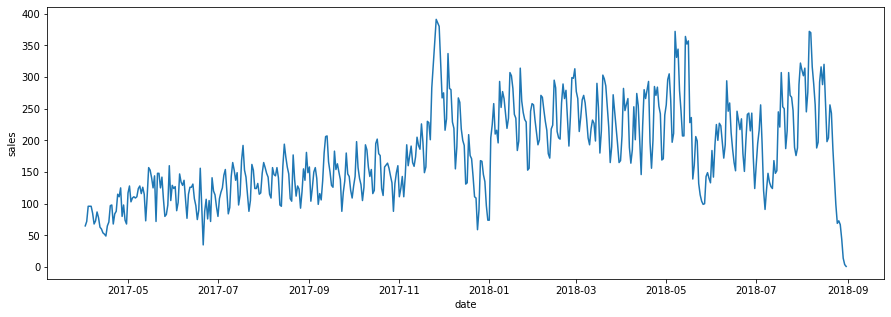

In [43]:
plt.figure(figsize=(15,5))
plt.plot(daily_sales_df)
plt.xlabel('date')
plt.ylabel('sales');

# Train-Test Split

The cleaned data has consistent trend without any irregularities, so this time series is used for further analytics. Test size is selected as a quarter of the data points based on which the time series is split into train and test series as follows:

In [44]:
test_size = int(daily_sales_df.shape[0] * 0.25)
train_df = daily_sales_df.iloc[:-test_size]
test_df = daily_sales_df.iloc[-test_size:]

The train test split is visualized in the time series as follows:

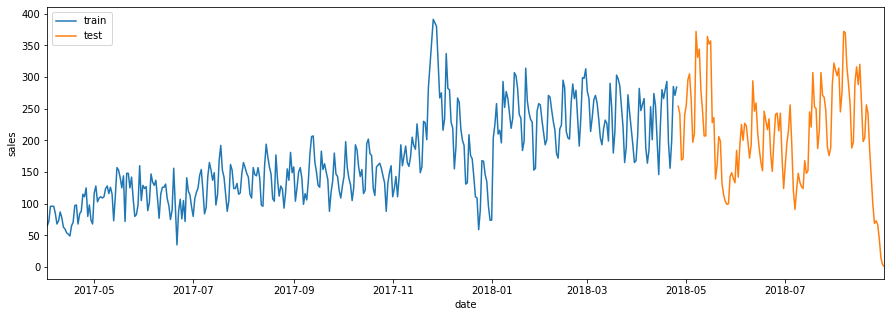

In [45]:
plt.figure(figsize=(15,5))
plt.plot(train_df, label='train')
plt.plot(test_df, label='test')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

# Naive Model

In [46]:
test_df

,sales
purchase_date,
2018-04-26,254
2018-04-27,242
2018-04-28,169
2018-04-29,171
2018-04-30,240
...,...
2018-08-27,67
2018-08-28,44
2018-08-29,14


The naive method simply substitutes the last value in the train set as forcast for all test points as follows:

In [47]:
naive_predictions = test_df.copy()
naive_predictions.iloc[:, 0] = train_df.iloc[-1, 0]
naive_predictions

,sales
purchase_date,
2018-04-26,284
2018-04-27,284
2018-04-28,284
2018-04-29,284
2018-04-30,284
...,...
2018-08-27,284
2018-08-28,284
2018-08-29,284


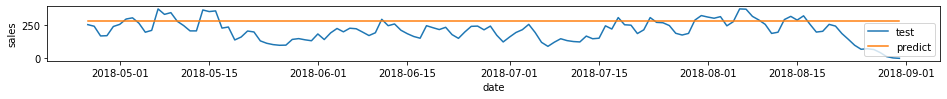

In [53]:
plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(naive_predictions, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

In [54]:
naive_rmse = sqrt(mean_squared_error(test_df, naive_predictions))
print('RMSE:', naive_rmse)

RMSE: 107.34589244586864


# AR Model

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag: 2
Coefficients: const       26.961898
L1.sales     0.898431
L2.sales    -0.056049
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


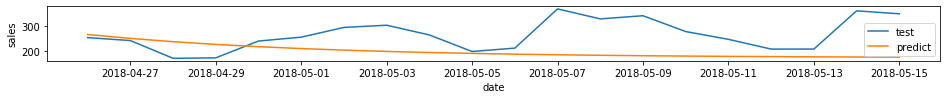

In [55]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=2)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag2_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag2_20_df = pd.DataFrame({'predictions': predictions_lag2_20.values}, index=test_df[:20].index)

plt.figure(figsize=(16,1))
#plt.plot(train_df, label='train')
plt.plot(test_df[:20], label='test')
plt.plot(predictions_lag2_20_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


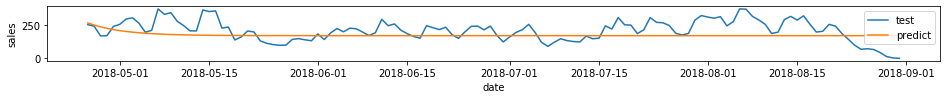

In [56]:
predictions_lag2 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag2_df = pd.DataFrame({'predictions': predictions_lag2.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(predictions_lag2_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Lag: 10
Coefficients: const        10.922368
L1.sales      0.676918
L2.sales     -0.046602
L3.sales      0.057250
L4.sales      0.057840
L5.sales     -0.089222
L6.sales      0.210035
L7.sales      0.387288
L8.sales     -0.121266
L9.sales     -0.194888
L10.sales     0.003188
dtype: float64


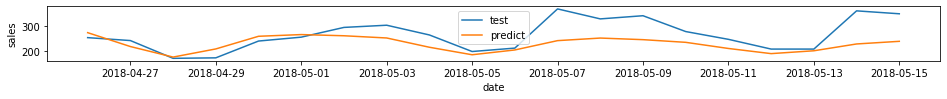

In [57]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=10)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag10_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag10_20_df = pd.DataFrame({'predictions': predictions_lag10_20.values}, index=test_df[:20].index)

plt.figure(figsize=(16,1))
plt.plot(test_df[:20], label='test')
plt.plot(predictions_lag10_20_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


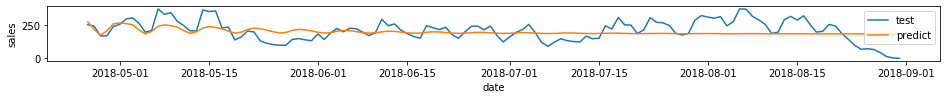

In [58]:
predictions_lag10 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag10_df = pd.DataFrame({'predictions': predictions_lag10.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(predictions_lag10_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

Increasing the lag improves the forcasting performance in the starting region of the test set; however, it gradually dies out as is the typical of the AR model.

In [78]:
lag10_rmse = sqrt(mean_squared_error(test_df, predictions_lag10_df))
print('RMSE:', lag10_rmse)

RMSE: 76.28446918754402


Lag: 6
Coefficients: const       9.613006
L1.sales    0.763436
L2.sales   -0.223603
L3.sales    0.067986
L4.sales    0.078510
L5.sales   -0.166701
L6.sales    0.429954
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


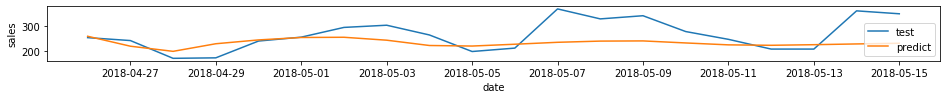

In [60]:
from statsmodels.tsa.ar_model import AR

ar = AR(train_df)
ar_fit = ar.fit(maxlag=6)

print('Lag: %s' % ar_fit.k_ar)
print('Coefficients: %s' % ar_fit.params)

predictions_lag10_20 = ar_fit.predict(start=len(train_df), end=len(train_df)+19)
predictions_lag10_20_df = pd.DataFrame({'predictions': predictions_lag10_20.values}, index=test_df[:20].index)

plt.figure(figsize=(16,1))
plt.plot(test_df[:20], label='test')
plt.plot(predictions_lag10_20_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


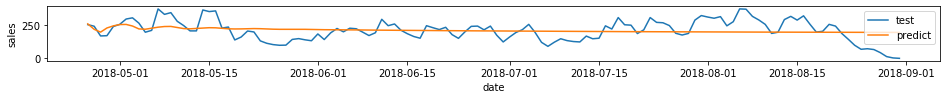

In [61]:
predictions_lag10 = ar_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
predictions_lag10_df = pd.DataFrame({'predictions': predictions_lag10.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(predictions_lag10_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

# ARIMA Model

Through trials and errors, 6, 2, 5 have been identified as the optimal coefficients for the AR, I, and MA components, respectively.

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima = SARIMAX(train_df, order=(6, 2, 5),
                enforce_stationarity=False, 
                enforce_invertibility=False)
arima_fit = arima.fit()

print('Coefficients: %s' % arima_fit.params)

C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Coefficients: ar.L1       0.334286
ar.L2      -1.220450
ar.L3       0.278701
ar.L4      -0.844533
ar.L5      -0.312765
ar.L6      -0.163331
ma.L1      -1.637075
ma.L2       1.773002
ma.L3      -1.795965
ma.L4       1.350378
ma.L5      -0.688911
sigma2    822.450337
dtype: float64


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


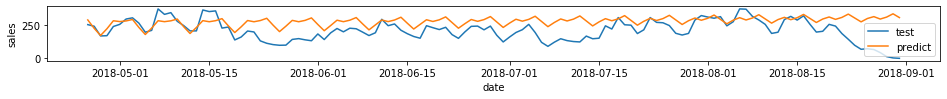

In [63]:
arima_predictions = arima_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1)
arima_predictions_df = pd.DataFrame({'predictions': arima_predictions.values}, index=test_df.index)

plt.figure(figsize=(16,1))
plt.plot(test_df, label='test')
plt.plot(arima_predictions_df, label='predict')
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

Addition of integration and moving average components helps to sustain the forcast.

In [64]:
print('RMSE:', sqrt(mean_squared_error(test_df, arima_predictions_df)))

RMSE: 103.69302488266266


# Facebook Prophet

In [65]:
daily_sales_df

,sales
purchase_date,
2017-04-02,65
2017-04-03,72
2017-04-04,96
2017-04-05,96
2017-04-06,96
...,...
2018-08-27,67
2018-08-28,44
2018-08-29,14


In [66]:
sales_df = pd.DataFrame(orders_df.groupby('purchase_date')['order_id'].count())
daily_sales_prohpet_df = daily_sales_df.reset_index()
daily_sales_prohpet_df.columns = ['ds', 'y']
daily_sales_prohpet_df.head()

,ds,y
0,2017-04-02,65
1,2017-04-03,72
2,2017-04-04,96
3,2017-04-05,96
4,2017-04-06,96


In [67]:
train_prophet_df = daily_sales_prohpet_df.iloc[:-test_size]
test_prophet_df = daily_sales_prohpet_df.iloc[-test_size:]

In [68]:
holidays = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2018-12-01', '2018-12-02', '2018-12-08',
                        '2018-12-09', '2018-12-13', '2018-12-15',
                        '2018-12-16', '2018-12-22', '2018-12-23',
                        '2018-12-24', '2018-12-25', '2018-12-26',
                        '2018-12-27', '2018-12-28']),
 
})

In [69]:
from fbprophet import Prophet 
prophet = Prophet(interval_width=0.95, holidays=holidays)
prophet.fit(train_prophet_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
future = prophet.make_future_dataframe(periods=test_size, freq='D' , include_history=False)

In [71]:
forecast = prophet.predict(future)

In [72]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-04-26,253.985749,195.370402,330.774976,253.985560,253.985803,9.508925,9.508925,9.508925,0.0,...,0.0,0.0,0.0,9.508925,9.508925,9.508925,0.0,0.0,0.0,263.494674
1,2018-04-27,254.416353,175.793361,319.829739,254.415354,254.416954,-9.810870,-9.810870,-9.810870,0.0,...,0.0,0.0,0.0,-9.810870,-9.810870,-9.810870,0.0,0.0,0.0,244.605482
2,2018-04-28,254.846956,137.800131,286.489787,254.844707,254.848524,-41.534969,-41.534969,-41.534969,0.0,...,0.0,0.0,0.0,-41.534969,-41.534969,-41.534969,0.0,0.0,0.0,213.311987
3,2018-04-29,255.277560,162.248004,308.514485,255.273554,255.280686,-20.850444,-20.850444,-20.850444,0.0,...,0.0,0.0,0.0,-20.850444,-20.850444,-20.850444,0.0,0.0,0.0,234.427116
4,2018-04-30,255.708163,200.101291,347.621916,255.702611,255.713009,22.049910,22.049910,22.049910,0.0,...,0.0,0.0,0.0,22.049910,22.049910,22.049910,0.0,0.0,0.0,277.758073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2018-08-27,306.949986,259.295187,400.448017,306.309218,307.588185,22.049910,22.049910,22.049910,0.0,...,0.0,0.0,0.0,22.049910,22.049910,22.049910,0.0,0.0,0.0,328.999895
124,2018-08-28,307.380589,266.199056,404.285998,306.734074,308.026406,23.799938,23.799938,23.799938,0.0,...,0.0,0.0,0.0,23.799938,23.799938,23.799938,0.0,0.0,0.0,331.180527
125,2018-08-29,307.811193,247.501532,401.609444,307.158990,308.464289,16.837511,16.837511,16.837511,0.0,...,0.0,0.0,0.0,16.837511,16.837511,16.837511,0.0,0.0,0.0,324.648703
126,2018-08-30,308.241796,246.180400,387.002238,307.583684,308.902171,9.508925,9.508925,9.508925,0.0,...,0.0,0.0,0.0,9.508925,9.508925,9.508925,0.0,0.0,0.0,317.750721


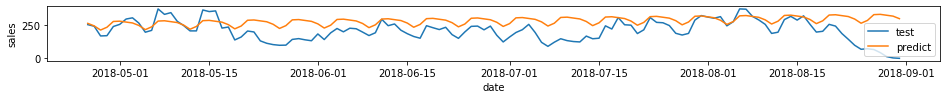

In [73]:
plt.figure(figsize=(16,1))
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], label='test')
plt.plot(test_prophet_df['ds'], forecast['yhat'], label='predict') 
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

In [74]:
print("RMSE: ", sqrt(mean_squared_error(test_prophet_df['y'], forecast['yhat'])))

RMSE:  104.1410732856418


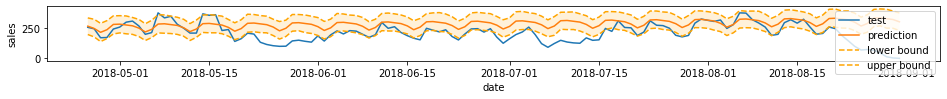

In [75]:
test = test_prophet_df
plt.figure(figsize=(16,1))
plt.plot(test['ds'], test['y'].values, label="test")
plt.plot(test['ds'], forecast['yhat'].values, label="prediction")
plt.plot(test['ds'], forecast['yhat_lower'].values, c="orange", label="lower bound", linestyle='--')
plt.plot(test['ds'], forecast['yhat_upper'].values, c="orange", label="upper bound", linestyle='--')
ax = plt.gca()
ax.fill_between(test['ds'],  forecast['yhat_lower'], forecast['yhat_upper'], facecolor='orange', alpha=0.15, interpolate=True)
plt.legend()
plt.xlabel('date')
plt.ylabel('sales');

The results show that the test data is contained within the upper and lower bounds of the uncertainty intervals.